In [16]:
%%shell
git clone https://github.com/pytorch/vision.git     # do
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 10769 (delta 20), reused 11 (delta 2), pack-reused 10726
Receiving objects: 100% (10769/10769), 12.00 MiB | 19.78 MiB/s, done.
Resolving deltas: 100% (7483/7483), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be37608 version check against PyTorch's CUDA version


In [18]:
import torch
import matplotlib.pyplot as plt
import numpy as np

import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.optim as optim
import seaborn as sns

from sklearn.model_selection import train_test_split
from engine import train_one_epoch, evaluate
from torch.autograd import Variable

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!





/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
batch_size = 4
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

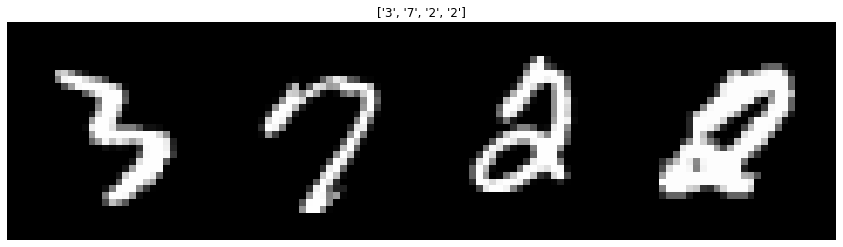

In [5]:
def imshow(img, title):
    plt.figure(figsize=(batch_size * 4, 4))
    plt.axis('off')
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.title(title)
    plt.show()

def show_batch_images(dataloader):
    images, labels = next(iter(dataloader))   
    img = torchvision.utils.make_grid(images)
    imshow(img, title=[str(x.item()) for x in labels])
    return images, labels

images, labels = show_batch_images(trainloader)

In [6]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True)

In [19]:
class MyNet(nn.Module):
    def __init__(self): 
        super(MyNet, self).__init__()
        self.classifier = nn.Sequential(
                            nn.Linear(784, 500), 
                            nn.ReLU(),
                            nn.Linear(500, 100),
                            nn.ReLU(),
                            nn.Linear(100, 10), 
                            nn.Softmax()
                            )
             
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model = MyNet().to(device)
print(model)

MyNet(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=10, bias=True)
    (5): Softmax(dim=None)
  )
)


In [8]:
class MyNet_CNN(nn.Module):
    def __init__(self): 
        super(MyNet_CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, 3),           # (N, 1, 28, 28) -> (N, 64, 26, 26)
            nn.ReLU(),
            nn.Conv2d(64, 32, 3),          # (N, 64, 26, 26) -> (N, 32, 24, 24) 
            nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.Linear(18432, 10),         # (N, 18432) -> (N, 10)
            nn.Softmax()
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model2 = MyNet_CNN().to(device)
print(model2)

MyNet_CNN(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=18432, out_features=10, bias=True)
    (1): Softmax(dim=None)
  )
)


In [10]:
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(model.parameters(), lr=0.01)

In [23]:
def fit (trainloader, model, opt, loss_function, epochs=1000, device=device, verbose=False) :
    # model = model.to(device)
    for epoch in range(epochs) :
        if verbose : print('Epoch number -> ', epoch)
        model.train()
        all_loss = []
        for i,(images,labels) in enumerate(trainloader) :
            images, labels = images.to(device), labels.to(device)
            # images = Variable(images)
            # labels = Variable(labels)
            opt.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            if verbose : 
                all_loss.append(loss.item())
                print(loss.item())
            loss.backward()
            opt.step()
        # if verbose : print(sum(all_loss))
    return loss.item()

In [24]:
# device = torch.device('cuda')
fit (trainloader, model, opt, loss_function=loss_fn, epochs=5, device=device, verbose=True)

Epoch number ->  0
2.2908661365509033
2.3049850463867188
2.2999439239501953
2.3032193183898926
2.3000383377075195
2.307727336883545
2.3017396926879883
2.299982786178589
2.3000810146331787
2.3027586936950684
2.300440788269043
2.3038434982299805
2.3029332160949707
2.304460048675537
2.300435781478882
2.307135581970215
2.304062843322754
2.3029775619506836
2.306178331375122
2.305518627166748
2.2970736026763916
2.3051702976226807
2.305093765258789
2.3034439086914062
2.3050944805145264
2.3005223274230957
2.303152084350586
2.309786081314087
2.3030240535736084
2.305962324142456
2.298996925354004
2.308152914047241
2.307861804962158
2.3083629608154297
2.3035995960235596
2.3066112995147705
2.303110122680664
2.304217576980591
2.303098201751709
2.306034564971924
2.3053841590881348
2.3055920600891113
2.3006722927093506
2.298630475997925
2.299959897994995
2.2965822219848633
2.302699565887451
2.3068273067474365
2.299973964691162
2.3049075603485107
2.298156261444092
2.29950213432312
2.301419734954834
2.

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


2.2999112606048584
2.2997443675994873
2.305041790008545
2.2978527545928955
2.3024280071258545
2.3049938678741455
2.2992794513702393
2.307523012161255
2.2999415397644043
2.3025858402252197
2.3067381381988525
2.29913067817688
2.3076372146606445
2.300429582595825
2.304030418395996
2.2992563247680664
2.3048179149627686
2.3002288341522217
2.304673194885254
2.305069923400879
2.3013882637023926
2.310025453567505
2.3038673400878906
2.3009815216064453
2.298171043395996
2.304945945739746
2.3028817176818848
2.306617259979248
2.3078343868255615
2.303755283355713
2.303830862045288
2.3025217056274414
2.303689956665039
2.3084003925323486
2.3047866821289062
2.3005940914154053
2.3008666038513184
2.303175926208496
2.2978267669677734
2.3001790046691895
2.3019983768463135
2.3043465614318848
2.3059816360473633
2.300828456878662
2.298452854156494
2.2997400760650635
2.306384325027466
2.297049045562744
2.303524971008301
2.302638053894043
2.3037073612213135
2.309032440185547
2.3040010929107666
2.29781866073608

KeyboardInterrupt: ignored

In [20]:
# for epoch in range(50): 
#     train_one_epoch(model, opt, trainloader, device, epoch, print_freq=20)

AttributeError: ignored

In [ ]:
# for data in trainloader :
#     images, labels = data 
#     opt.zero_grad()
#     outputs = model(inputs)
#     loss = loss_fn(outputs, labels)
#     loss.backward()
#     opt.step()

In [ ]:
#predict first 4 images in the test set
abc = model.predict(X_test[:4])
print(abc)
plt.imshow(abc, cmap = plt.cm.binary)
plt.show()